In [1]:
import warnings
import seaborn as sns
import tensorflow_probability as tfp  # tensorflow probability
import jax  # autograd + XLA
import jax.numpy as jnp  # ai-accelerator agnostic numpy implementations
import pandas as pd  # lets us handle data as dataframes
import matplotlib.pyplot as plt  # sets up plotting under plt
import matplotlib.cm as cm  # allows us easy access to colormaps
import matplotlib as mpl  # this actually imports matplotlib
import scipy as sp  # imports stats functions, amongst other things
import numpy as np  # imports a fast numerical programming library
from operator import index
from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit
import optax as ox
key = jr.PRNGKey(123)

warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
import seaborn as sns

In [3]:
n = 1000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

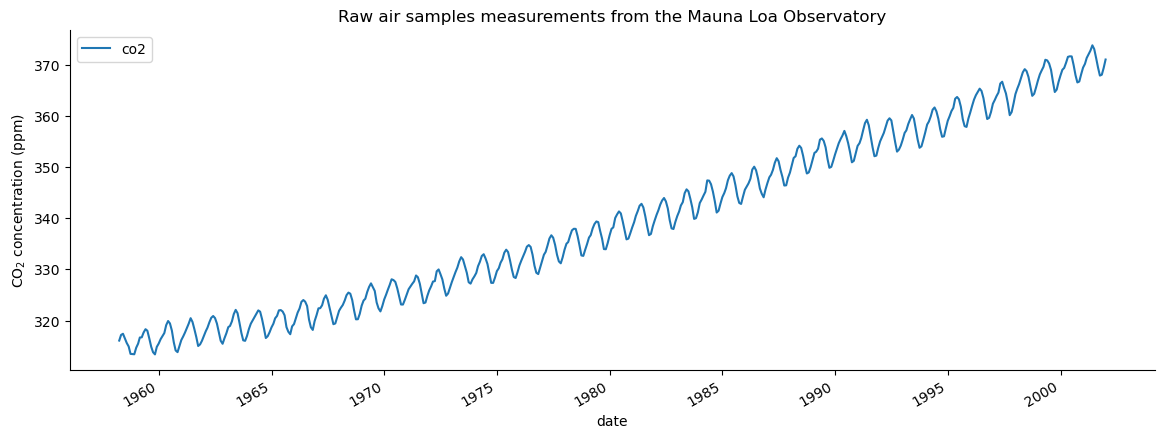

In [4]:
from sklearn import datasets
co2_dataset = datasets.fetch_openml(data_id=41187, as_frame=True)
co2_df = co2_dataset.frame
co2_df["date"] = pd.to_datetime(co2_df[["year", "month", "day"]])
co2_df = co2_df[["date", "co2"]].set_index("date")
co2_df = co2_df.resample("M").mean().dropna(axis="index", how="any")

co2_df.plot(figsize=(14, 5))
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
sns.despine()


In [5]:
# X = (co2_df.index.year + co2_df.index.month / 12).to_numpy().reshape(-1, 1)
# from sklearn import preprocessing as sp
# s = 200
# n = 450
# scaler = sp.StandardScaler()
# scaler = scaler.fit(X[s:n])
# x = scaler.transform(X[s:n])
# y = jnp.array(co2_df["co2"][s:n])
# min_max = sp.MinMaxScaler(feature_range=(0, 5))
# min_max = min_max.fit(y.reshape(-1, 1))
# y = min_max.transform(y.reshape(-1, 1))


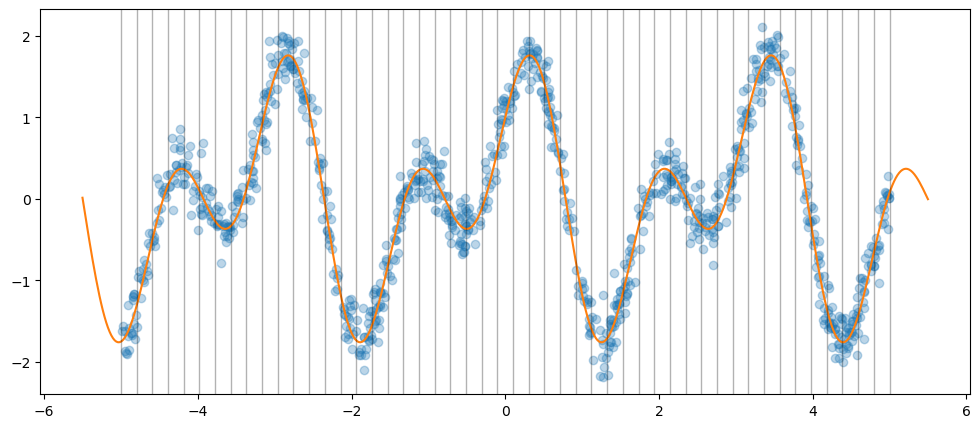

In [6]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3, label = "Samples")
ax.plot(xtest, f(xtest), label = "True function")
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()

In [7]:
from sklearn.gaussian_process.kernels import ExpSineSquared

In [8]:
import numpy as np
import random
from scipy.optimize import minimize
import time
from scipy import spatial as spt
import seaborn as sns
history = []
def Kernel(squared_distances, Lin, Var):
    return (Var**2)*np.exp(-1/(2*Lin**2)*squared_distances)

# def Kernel(squares, length_scale, variance):
#     e.cdist(X, X, metric='sqeuclidean')
#     return variance * jnp.exp(-1/(2*length_scale**2) * squares)

def FindSquareDistances(X, Xm=None):
        if Xm is not None:
            return spt.distance.cdist(X, Xm, metric='sqeuclidean')
        else:
            return spt.distance.cdist(X, X, metric='sqeuclidean')

# def FindSquareDistances(X, Xm= None):
#         if Xm is not None:
#             return 4*(np.sin(3.1415* np.abs(X - Xm)))**2
#         else:

def Train(Lin, Var, Sigma, X, Y, N, M, NoCandidates):
    X = np.vstack(X)    
    Y = np.vstack(Y)    
    start_time = time.time()    # Note 
    Theta = [Lin, Var, Sigma]          # GP hyperparameters

    # Loop over all the candidate sparse points
    for r in range(NoCandidates):

        indices = random.sample(range(N), M)
        X_candidate = X[indices]

        a = (X, Y, X_candidate, N, M)
        LB = -NegLowerBound(Theta, a)

        print(f"Considering inducing point {[ V for V in indices]} now.")
        print(f"LB = {LB}")

        if r == 0:              # For the first set of candidate points
            Xs = X_candidate    # Define optimum sparse inputs found so far
            Ys = Y[indices]    
            LB_best = LB       
        else:
            if LB > LB_best:      
                Xs = X_candidate  # Define optimum sparse inputs found so far
                Ys = Y[indices]   # Define optimum sparse outputs found so far
                LB_best = LB      

    # Update hyperparameters using scipy.minimize
    a = (X, Y, Xs, N, M)  # Arguments needed as input to 'minimize' function
    b1 = (1e-3, 1)        # Bounds on length scale
    b2 = (1e-3, 1)      # Bounds on signal variance
    b3 = (1e-3, 3)      # Bounds on noise variance
    bnds = (b1, b2, b3)
    history = []
    def callback(x_theta):
        fobj = NegLowerBound(x_theta, a)
        history.append(fobj)

    # Search for optimum hyperparameters
    sol = minimize(NegLowerBound, x0=Theta, args=(a, ),
                   method='L-BFGS-B', bounds=bnds, callback = callback)

    [print(f"Iteration {i} : {history[i]}") for i in range(len(history))]
    Theta = sol.x

    Lin, Var, Sigma = Theta                         # Extract hyperparameters
    K = Kernel(FindSquareDistances(Xs), Lin, Var)   # Gram matrix
    C = K + Sigma**2 * np.eye(M)            
    invC = np.linalg.inv(C)                  # Find inverse of C (as in paper!!)
    elapsed_time = time.time() - start_time  # Time taken for training

    

    return Lin, Var, Sigma, K, C, invC, Xs, Ys, LB_best, elapsed_time


def NegLowerBound(Theta, a):
    X, Y, Xs, N, M = a  # Extract arguments
    Lin, Var, Sigma = Theta    # Extract hyperparameters
    K_MM = Kernel(FindSquareDistances(Xs), Lin, Var)     # Find K_MM
    InvK_MM = np.linalg.inv(K_MM)                 # Find inverse of K_MM
    K_NM = Kernel(FindSquareDistances(X, Xs), Lin, Var)  # Find K_NM
    K_MN = np.transpose(K_NM)                     # Find K_MN

    # We define A = K_NM^T * invK_MM * K_MN
    A = np.dot(K_NM, np.dot(InvK_MM, K_MN))
    # print("CAME HERE!")
    
    B = np.zeros(N)
    for i in range(N):
        B[i] = 1 - A[i, i]

    # Calculate the (negative) lower bound
    C = A+np.eye(N)*Sigma**2
    Sign, LogDetC = np.linalg.slogdet(C)
    LogDetC = Sign*LogDetC
    NLB = -(-0.5*LogDetC - 0.5*np.dot(Y.T, np.dot(np.linalg.inv(C), Y))
            - 1/(2*Sigma**2)*np.sum(B))
    return NLB.ravel()



def Predict(X, xStar, Lin, Var, Sigma, Y, K, C, InvC, N):
    ''' Standard GP prediction
    '''
    if np.size(X[0]) == 1:
        squared_distances = (X-xStar)**2
    else:
        squared_distances = np.sum((X-xStar)**2, 1)
    k = Kernel(squared_distances, Lin, Var)
    c = 1 + Sigma**2   # Always true for this particular kernel
    yStarMean = np.dot(k.T, np.dot(InvC, Y))
    yStarStd = np.sqrt(c - np.dot(k.T, np.dot(InvC, k)))

    if c - np.dot(k.T, np.dot(InvC, k)) < 0:
        print("HELLELUHAH :", c - np.dot(k.T, np.dot(InvC, k)))
        print("AAAAA WE ENTERED THIS PLACE")
    return yStarMean, yStarStd

In [9]:
Theta = 0.413, 1.85

Ran for 4 minutes -- nothing showing for 10,000 data points.

In [10]:
L = 2, 3
a, b = L
b

3

In [14]:
N = 1000

Considering inducing point [40, 468, 982, 595, 531, 286, 671, 475, 899, 221, 394, 741, 888, 574, 841, 886, 658, 50, 649, 635, 866, 471, 815, 563, 751, 196, 656, 213, 270, 327, 486, 845, 510, 746, 450, 561, 836, 881, 398, 315, 451, 103, 570, 742, 977, 170, 146, 779, 766, 68] now.
LB = [20624.44838916]
Considering inducing point [847, 613, 609, 533, 529, 982, 153, 84, 943, 729, 205, 902, 967, 658, 538, 428, 756, 329, 288, 804, 254, 281, 210, 979, 508, 147, 710, 244, 766, 476, 206, 682, 876, 318, 728, 35, 422, 921, 816, 737, 639, 771, 942, 169, 866, 895, 308, 387, 111, 233] now.
LB = [39061.84353252]
Considering inducing point [239, 570, 845, 423, 97, 624, 914, 112, 402, 144, 339, 659, 983, 19, 785, 37, 697, 823, 712, 873, 490, 835, 256, 53, 506, 612, 34, 384, 354, 779, 795, 535, 103, 499, 801, 129, 240, 660, 684, 359, 98, 647, 374, 229, 749, 936, 92, 7, 923, 482] now.
LB = [39261.82792836]
Considering inducing point [217, 344, 427, 809, 363, 806, 543, 747, 62, 838, 643, 72, 129, 763, 486

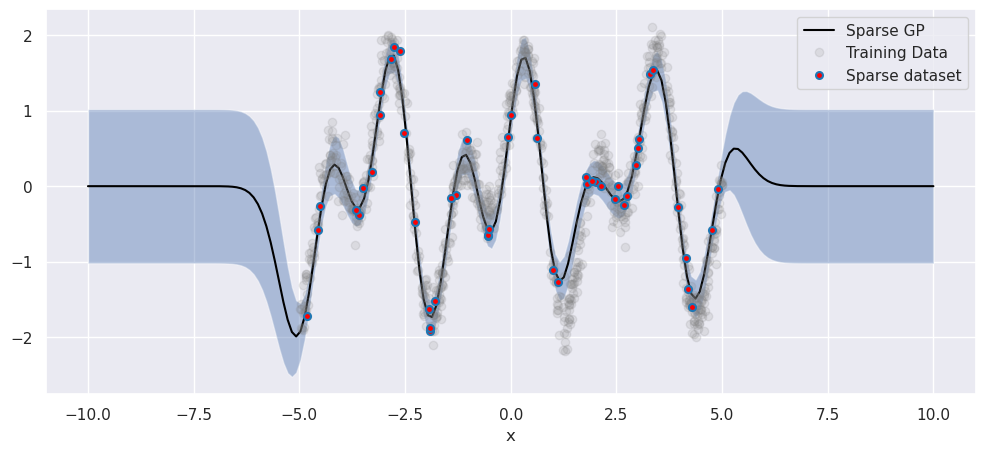

[]

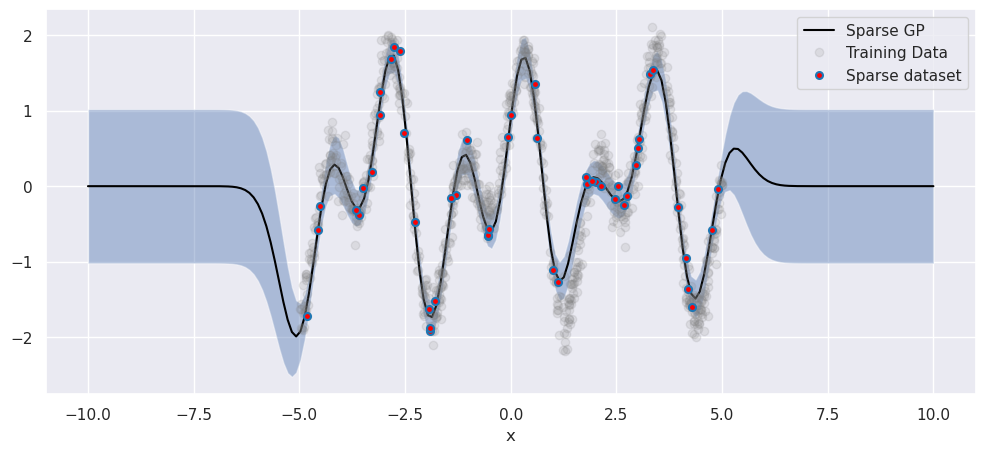

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
"""
BASED ON CODE FROM
University of Liverpool
GITHUB REPO IN PRESENTATION!
"""

X = x
Y = y
# Initial hyperparameters
L0 = 0.5      # Lengthscale
V0 = 2.0        # Signal Variance
Sigma0 = 0.2    # Observation Variance

# Train sparse GP
M = 50              # No. sparse points
NoCandidates = 5      # No. of candidate sets of sparse points analysed
(Lin, Var, Sigma, K, C, InvC, Xs, Ys, LB_best, elapsed_time) = Train(L0, V0, Sigma0,
                                                                  X, Y, N, M,
                                                                  NoCandidates)

print('Maximum lower bound:', LB_best)
print('Hyperparameters:', Lin, Var, Sigma)
print('Elapsed time:', elapsed_time)

# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)

# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.show()

Lin = 0.5
Var = 1
# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)

# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.plot()


In [16]:
Theta = [0.7043199215617603, 1.0, 0.487]
a = (X, Y, Xs, N, M)
print("Initial Lower Bound: ", NegLowerBound(Theta, a))

Initial Lower Bound:  [-4856.93983591]


In [18]:
mean_standardized_log_loss(Y, Y_StarMean, Y_StarStd)

8.455186

In [17]:
def mean_standardized_log_loss(
    y_true, y_pred, y_std, *, sample_weight=None, multioutput="uniform_average", squared=True
):
    """Mean standardized log loss.
    Read more in the :ref:`User Guide <mean_standardized_log_loss>`.
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    y_std : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated standard deviation in predictions.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like of shape \
            (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.

    Returns
    -------
    loss : float or ndarray of floats
        A non-negative floating point value (the best value is 0.0), or an
        array of floating point values, one for each individual target.
    Examples
    --------
    >>> from sklearn.metrics import mean_standardized_log_loss
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> y_std = [0.1, 0, 0.05, 0.3]
    >>> mean_standardized_log_loss(y_true, y_pred, y_std)
    6.356
    >>> y_true = [[0.5, 1],[-1, 1],[7, -6]]
    >>> y_pred = [[0, 2],[-1, 2],[8, -5]]
    >>> y_std = [[0.01, 0.02],[0.01,0.04],[0.03,0.04]]
    >>> mean_standardized_log_loss(y_true, y_pred, y_std)
    5.511
    >>> mean_squared_error(y_true, y_pred, multioutput='raw_values')
    array([5.00107605, 6.02159874])
    >>> mean_squared_error(y_true, y_pred, multioutput=[0.3, 0.7])
    2.858
    """
    # y_type, y_true, y_pred, multioutput = _check_reg_targets(
    #   y_true, y_pred, multioutput
    # )
    # check_consistent_length(y_true, y_pred, sample_weight)
    
    ###########
    # Checks like the above ones to be implemented.
    ###########
    
    first_term = 0.5 * np.log(2 * np.pi * y_std**2)
    second_term = ((y_true - y_pred)**2)/(2 * y_std**2)
    
    output_errors = np.average(first_term + second_term, axis=0, weights=sample_weight)

    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

# IGNORE -- SGD IMPLEMENTATION NOT WORKING


In [19]:
import numpy as np
from scipy.optimize import OptimizeResult


def sgd(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.001,
    mass=0.9,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    x = x0
    velocity = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        velocity = mass * velocity - (1.0 - mass) * g
        x = x + learning_rate * velocity

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)


def rmsprop(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.1,
    gamma=0.9,
    eps=1e-8,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    """``scipy.optimize.minimize`` compatible implementation of root mean
    squared prop: See Adagrad paper for details.
    Adapted from ``autograd/misc/optimizers.py``.
    """
    x = x0
    avg_sq_grad = np.ones_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)
        x = x - learning_rate * g / (np.sqrt(avg_sq_grad) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)


def adam(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    """``scipy.optimize.minimize`` compatible implementation of ADAM -
    [http://arxiv.org/pdf/1412.6980.pdf].
    Adapted from ``autograd/misc/optimizers.py``.
    """
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        m = (1 - beta1) * g + beta1 * m  # first  moment estimate.
        v = (1 - beta2) * (g**2) + beta2 * v  # second moment estimate.
        mhat = m / (1 - beta1**(i + 1))  # bias correction.
        vhat = v / (1 - beta2**(i + 1))
        x = x - learning_rate * mhat / (np.sqrt(vhat) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)

# CONTINUE

In [20]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.linalg


class GP:

    def __init__(self, theta, kernel):

        self.theta = theta
        self.kernel_type = kernel

    def prior_kernel(self, x):
        if self.kernel_type == "Gaussian":
            return (self.theta[0]**2)*np.exp(-0.5*(x/self.theta[1])**2)
        # if self.kernel_type == "Matern":
            # PROBABLY NOT WORKING
            # NOT SURE
            # FIXME Matern Kernel formula
        #     return (self.theta[0]**2)*np.exp(-x/self.theta[1])



class VarGPRegression:

    def __init__(self, X_train, Y_train, kernel):
        self.X_train, self.Y_train = X_train.copy(), Y_train.copy()
        self.kernel_type = kernel
        self.sample_size = X_train.shape[0]
        self.selection = []
        self.indices = [*range(self.sample_size)]
        self.all_checked_set = set()

    def reset_prior(self, theta, sigma):
        """
        Used in M_Step
        """
        self.theta = theta
        self.sigma = sigma
        self.gp = GP(theta, self.kernel_type)
        self.Knn = self.K_matrix(self.X_train, self.X_train)

        self.X_induced = None
        self.index_induced = None
        self.Km = None
        self.Km_cholesky = None
        self.Kmn = None
        self.A = None
        self.mu = None

    def update_induced(self, indexes):
        self.index_induced = indexes
        self.X_induced = self.X_train[self.index_induced, :].copy()

        self.Km = self.K_matrix(
            self.X_induced, self.X_induced) + 10**(-8)*np.identity(self.X_induced.shape[0])
        self.Km_cholesky = np.linalg.cholesky(self.Km)
        self.Kmn = self.K_matrix(self.X_induced, self.X_train)

    def update_var_dist(self):
        Sigma_mat = self.Km + (1/self.sigma**2)*np.dot(self.Kmn, self.Kmn.T)
        L = np.linalg.cholesky(Sigma_mat)
        self.mu = (1/self.sigma**2)*np.dot(self.Km,
                                           scipy.linalg.cho_solve((L, True), np.dot(self.Kmn, self.Y_train)))
        self.A = np.dot(self.Km, scipy.linalg.cho_solve((L, True), self.Km))

    def K_matrix(self, X, Y):
        return self.gp.prior_kernel(cdist(X, Y))

    def covariance_cholesky(self):
        Qnn = np.dot(self.Kmn.T,
                     scipy.linalg.cho_solve((self.Km_cholesky, True), self.Kmn))
        return np.linalg.cholesky(Qnn + (self.sigma**2)*np.identity(self.sample_size))

    def trace_term(self):
        X = np.delete(self.X_train, self.index_induced, axis=0)
        Kpp = self.K_matrix(X, X)  # p = (n - m)
        Kpm = self.K_matrix(X, self.X_induced)
        return np.trace(Kpp - np.dot(Kpm,
                        scipy.linalg.cho_solve((self.Km_cholesky, True), Kpm.T)))

    def variationnal_bound(self):
        """ Computes the variational lower bound (FV in Titsias) that will be used
            in the greedy selection algorithm (select induced points and optimize
            hyperparameters)
        """

        n = self.sample_size
        L = self.covariance_cholesky()
        temp = scipy.linalg.cho_solve((L, True), self.Y_train)
        return -0.5*(np.vdot(self.Y_train, temp) + 2*np.sum(np.log(np.diag(L)))
                     + n*np.log(2*np.pi)
                     ) - (1/2*self.sigma**2)*self.trace_term()

    def posterior_mean(self, X):
        """ Computes the posterior mean of the Gaussian process for
            new observations X.
        """

        Kxm = self.K_matrix(X, self.X_induced)
        return np.dot(Kxm,
                      scipy.linalg.cho_solve((self.Km_cholesky, True), self.mu))

    def posterior_cov(self, X):
        """ Computes the posterior covariance matrix of the Gaussian process
            for new observations X.
        """

        Kxx = self.K_matrix(X, X)
        Kxm = self.K_matrix(X, self.X_induced)
        temp = scipy.linalg.cho_solve((self.Km_cholesky, True), Kxm.T)
        tempbis = scipy.linalg.cho_solve((self.Km_cholesky, True), self.A)
        return Kxx - np.dot(Kxm, temp) + np.dot(Kxm, np.dot(tempbis, temp)) + self.sigma**2


class Greedy(VarGPRegression):

    def E_step(self, J):

        result = J[0]
        self.update_induced(self.selection + [J[0]])
        temp = self.variationnal_bound()
        for j in J[1:]:
            self.update_induced(self.selection + [j])
            if temp < self.variationnal_bound():
                result = j

        print(f"Checking across {[F for F in J]}")
        self.all_checked_set.update([F for F in J])
        print(f"{result} added to list of indices.")
        self.selection.append(result)
        self.indices.remove(result)

    def M_step(self, theta0, sigma0):


        def objective(x):
            self.reset_prior(x[:-1], x[-1])
            self.update_induced(self.selection)
            return -self.variationnal_bound()
        init = np.hstack((theta0, sigma0))
        result = minimize(objective, init, method='BFGS',
                          options={'gtol': 1e-5, 'disp': True})
        print("theta* = ", result.x[:-1], "sigma* = ", result.x[-1])
        return result.x[:-1], result.x[-1], - result.fun

    def Greedy_selection(self, nbr_induced_points, theta0, sigma0, size):

        FV = []
        self.reset_prior(theta0, sigma0)
        for m in range(nbr_induced_points):
            print(m, "th step running")
            J = np.random.choice(self.indices, size=size)
            self.E_step(J)
            theta, sigma, f = self.M_step(theta0, sigma0)
            FV.append(f)
        return FV, self.all_checked_set


def predict(Greedy, X_test, theta0, sigma0, m, size):
    ML, all_checked_set = Greedy.Greedy_selection(m, theta0, sigma0, size)
    Greedy.update_var_dist()
    PM = Greedy.posterior_mean(X_test)
    std = np.sqrt(np.diag(Greedy.posterior_cov(X_test))).reshape(PM.shape)
    return PM, std, ML, all_checked_set


def plot_regression(Greedy, X_test, PM, std, ML):

    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plt.scatter(getattr(Greedy, "X_train"), getattr(
        Greedy, "Y_train"), marker='x', label='Training data')
    plt.plot(X_test, PM, 'b', label='mean prediction')
    plt.plot(X_test, PM - 2*std, '--',  color='red',
             label='Standard deviation')
    plt.plot(X_test, PM + 2*std, '--', color='red')
    plt.fill_between(X_test.reshape(-1), PM.reshape(-1) - 2*std.reshape(-1), PM.reshape(-1)+2*std.reshape(-1), alpha = 0.4, color = "tab:blue")
    plt.scatter(getattr(Greedy, "X_induced"), (min(PM - 2*std) - 0.5)*np.ones(getattr(
        Greedy, "X_induced").shape[0]), marker='+', color='r',  label='Induced points')
    # plt.legend(loc='lower right')
    plt.title("Trained Inducing Points, Titsias SGP")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(ML)+1), ML)
    plt.scatter(range(1, len(ML)+1), ML)
    plt.title("Variational lower bound")
    plt.xlabel("number of induced points")
    return


In [21]:
X_Star = X_Star.reshape(-1,1)

In [22]:
greedy = Greedy(X, Y, kernel="Gaussian")
PM, std, ML, all_checked = predict(greedy, X_Star, theta0=np.array(
    [1, 1]), sigma0=0.8, m=10, size=10)


0 th step running
Checking across [643, 777, 562, 516, 316, 143, 280, 11, 534, 986]
986 added to list of indices.
         Current function value: 1444.624424
         Iterations: 14
         Function evaluations: 160
         Gradient evaluations: 40
theta* =  [-0.1609269   0.62125745] sigma* =  0.9900175117141965
1 th step running
Checking across [754, 468, 711, 572, 508, 12, 173, 163, 672, 382]
672 added to list of indices.
         Current function value: 1432.012977
         Iterations: 15
         Function evaluations: 96
         Gradient evaluations: 24
theta* =  [-0.18487016  0.58903998] sigma* =  0.9719965602431324
2 th step running
Checking across [655, 235, 290, 554, 621, 481, 979, 941, 875, 51]
481 added to list of indices.
         Current function value: 1454.866622
         Iterations: 30
         Function evaluations: 318
         Gradient evaluations: 77
theta* =  [  3.23605835 -14.45424343] sigma* =  1.0252111567441087
3 th step running
Checking across [480, 360, 417

In [29]:
Y_ = Y[::5]

In [30]:
Y_.shape

(200, 1)

In [31]:
mean_standardized_log_loss(Y_, PM, std)

3.2713742

In [24]:
len(all_checked)

97

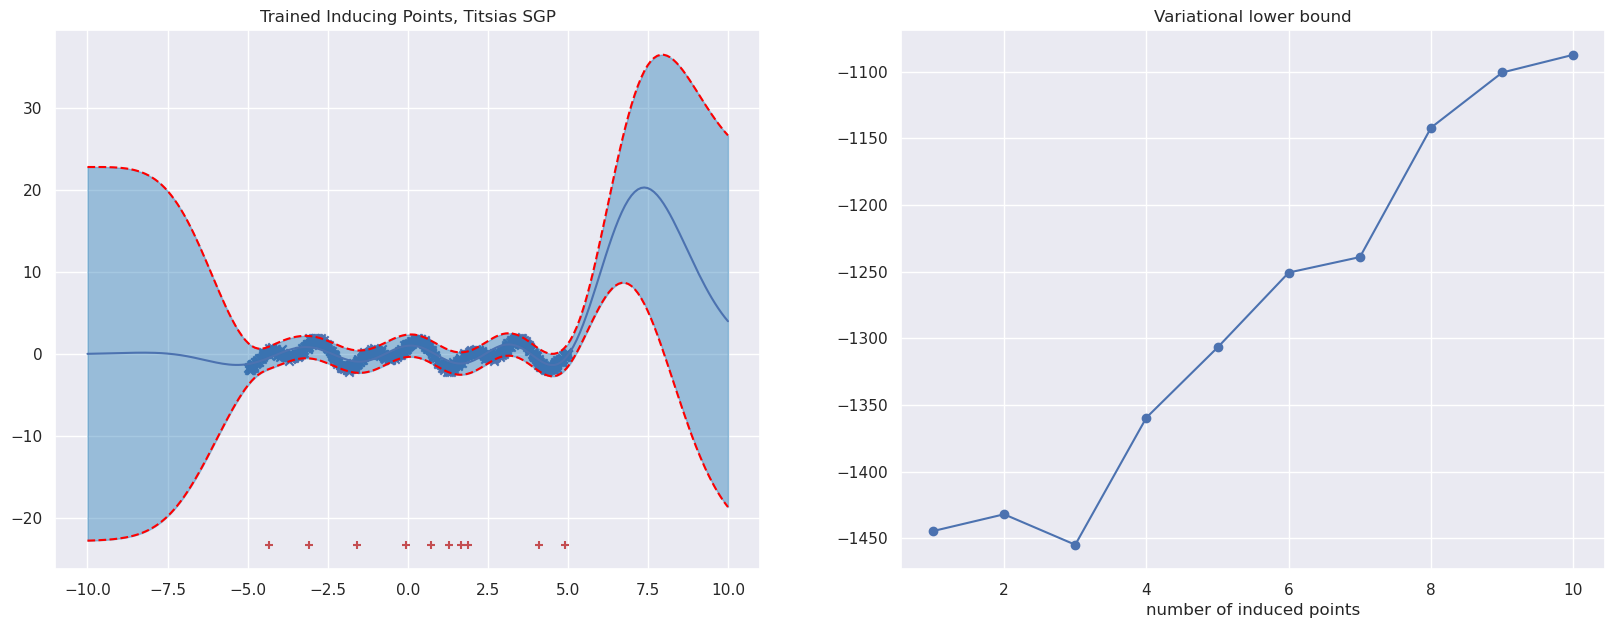

In [25]:
plot_regression(greedy , X_Star , PM , std , ML )

Text(0, 0.5, 'Number of unique inducing points sampled')

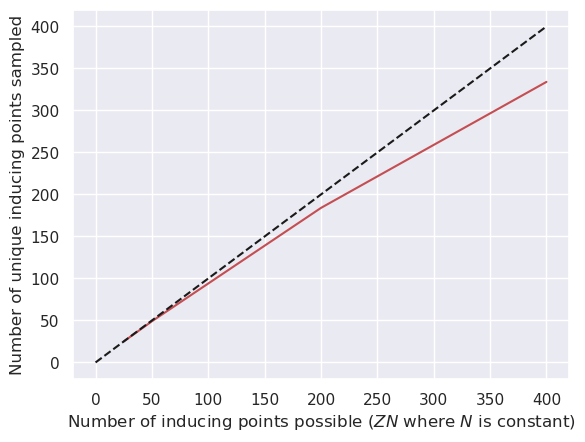

In [18]:
sns.set()
plt.plot([25, 50, 200, 400], [25, 49, 184, 334], "r")
plt.plot([0,400], [0,400], "k--")
plt.xlabel("Number of inducing points possible ($ Z N $ where $ N $ is constant)")
plt.ylabel("Number of unique inducing points sampled")

Deep NN vs GP --> 200-300 point datasets
